# A Tuorial on calculating correlations between bam files
## Introduciton
Correlating bam files is a quick quality control step for epigenetic analysis. 
With these tools we show how to quickly calculate correlations. 
We demonstrate these tools on real epigenetic data from the ENCODE project. 
This guide shows how to calculate counts from bam files and feed them into our statistics library (in python) to calculate and visulize the correlation (and association) between experiments. 

## Step 1) Gathering the example data
From the ENCODE project, we'll download sample bam files via wget command
```
sample=ENCLB584REF
wget https://www.encodeproject.org/files/${sample}/@@download/${sample}.bam
```

This is repeated for several ATAC-seq samples, including:
* ENCLB404SKN
* ENCLB605LCC
* ENCLB817BKI
* ENCLB907YRF

### Filtering bam files
For each bamfile we utilize samtools view command to filter the bam files.
An example is shown below.
```
samtools view -@ 10 -F 4 -F 256 -F 512 -F 1024 -F 2048 -q 30 -b ENCLB584REF.bam > ENCLB584REF.filtq30.bam
```

## Step 2) The "bam to fpkm" function

A critical step to begin analysis is to extract fragment counts across the genome from a bam file. 
To quickly generate these signals we have written a python tool called "bamtofpkm.py".

In [1]:
%%bash 
./bamtofpkm.py -h

usage: bamtofpkm.py [-h] -b B [B ...] [-W n] [-X chrM [chrM ...]]
                    [-O /Users/croth/ATAC-seq_Simulation/NOTEBOOKS] [-T n]
                    [-D n] [-N N] [-B B] [-r] [-f] [-c] [-V] [-S]

Calculates fragments along contigous bins within input bam files,
standardizing them to fpkm, and saves them as a bed file.

options:
  -h, --help            show this help message and exit
  -b B [B ...], --bam-files B [B ...]
                        Paths to input BAM files to count.
  -W n, --binsize n     Size in bp used to construct genomic windows, tiled
                        per chromosome from left to right, for calculating
                        fpkm (default: 10000).
  -X chrM [chrM ...], --exclude chrM [chrM ...]
                        Names of chromosomes to exclude from analysis
                        (default: chrM).
  -O /Users/croth/ATAC-seq_Simulation/NOTEBOOKS, --out /Users/croth/ATAC-seq_Simulation/NOTEBOOKS
                        The name of the output pat

### Calling the bamtofpkm function
Below is an example of its usage to generate a tab seperated file representing the output from these data. 
```
./bamtofpkm.py -b ENCLB584REF.filtq30.bam ENCLB907YRF.filtq30.bam -O ../DATA -N test.data
```
This executable can also be run via slurm and called via the sbatch command, as shown below. 
```
sbatch ./bamtofpkm.py -b ENCLB584REF.filtq30.bam ENCLB907YRF.filtq30.bam -O ../DATA -N test.data
```

## Step 3) Load input count data 
Now that we have generated this data we will load it into python using our functions in the epigenomevisulization library

In [2]:
## Load in our epi ftns
import epigenomevisulization as epv

## Set path to test data
test_path = '../DATA/ENCODE/test.data.tsv.gz'

## Load in data
test = epv.loaddf(test_path)

## Show the head
test.head()

,Chrom,Left,Right,ENCLB404SKN,ENCLB605LCC,ENCLB817BKI,ENCLB584REF,ENCLB907YRF
0,chr1,1,10000,1.0,1.0,1.0,1.0,1.0
1,chr1,10001,20000,1.0,1.0,1.0,1.0,0.0
2,chr1,20001,30000,1.0,1.0,1.0,1.0,1.0
3,chr1,30001,40000,1.0,1.0,1.0,1.0,1.0
4,chr1,40001,50000,1.0,1.0,1.0,0.0,0.0


## Step 4) Calculate the correlation without co-zeros
Below we show how to load in functions from our stats library and call correlation (and association) functions with and without co-zeros between samples.

In [3]:
## Load in our stats library for calcualting stats
import mystatslib as sims

## Gather the samples 
samples = epv.getsamples(test)

## Show the change in norm. mutual. info.
## Gather the x and y vectors
x,y = test[samples[0]].values, test[samples[1]].values

## Print the values of the co-zero removed Norm. Mutual info. 
sims.conmi(x,y,cozero=False), sims.conmi(x,y,cozero=True)

(0.7989040845114779, 0.6926977665848807)

In [4]:
## Show the change in Pearson's R
sims.copearson(x,y,cozero=False), sims.copearson(x,y,cozero=True)

(0.9320596843091306, 0.8815316961516578)

In [5]:
## Show the change in R2
sims.copearson(x,y,cozero=False)**2, sims.copearson(x,y,cozero=True)**2

(0.8687352551144361, 0.7770981313200188)

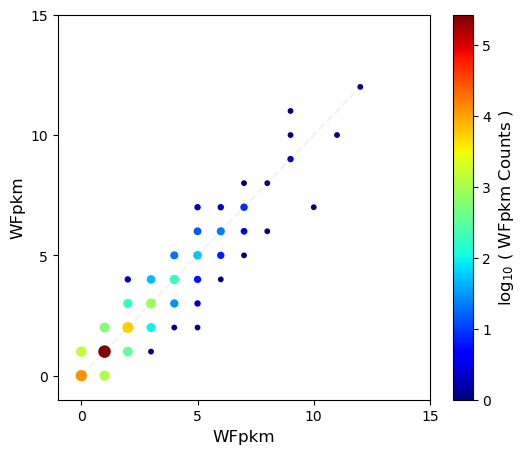

In [6]:
## Plot a comet plot shwoing the bi-variate scatter of first two replicates
epv.cometplot(x,y);

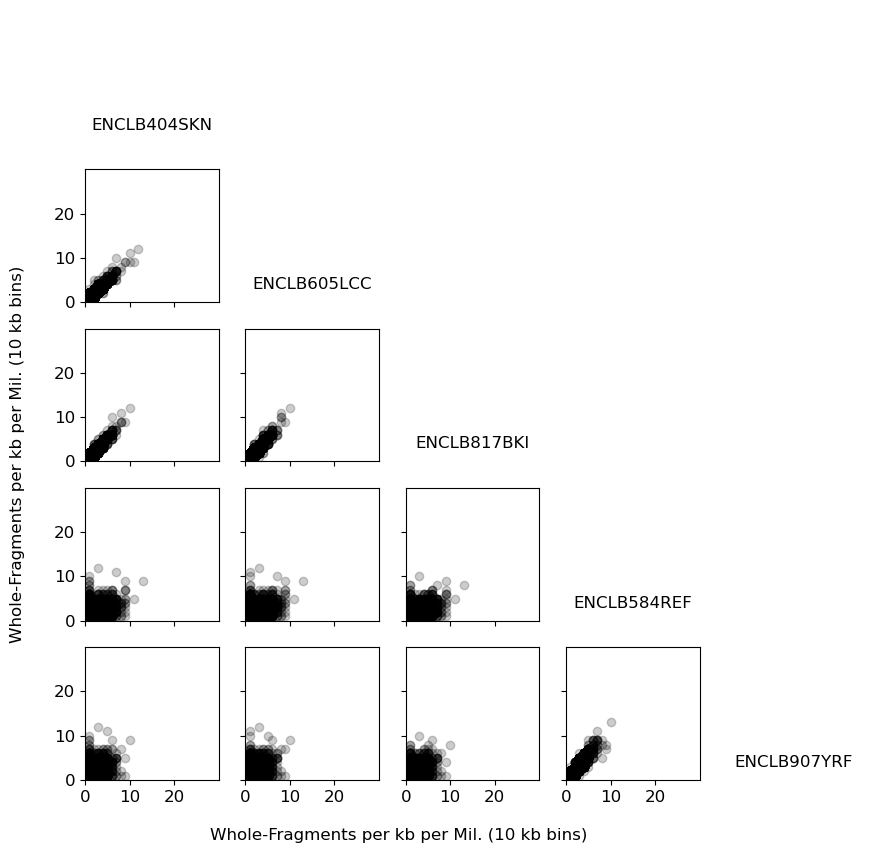

In [7]:
## Plot a correlation grid of the bi-variate scatter plots 
f,a = epv.corrgrid(test)

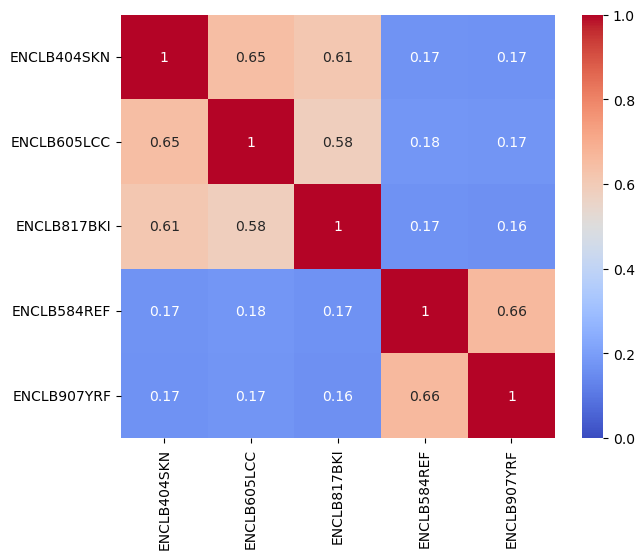

In [8]:
## call the corr table ftn 
tabel,ax = epv.corrtable(test,figsize=(7,5.5),corr='rsquared')

In [9]:
## Print the table to screen to check the correlation value
tabel

,ENCLB404SKN,ENCLB605LCC,ENCLB817BKI,ENCLB584REF,ENCLB907YRF
ENCLB404SKN,1.000000,0.647338,0.613416,0.170616,0.166190
ENCLB605LCC,0.647338,1.000000,0.582136,0.176378,0.172501
ENCLB817BKI,0.613416,0.582136,1.000000,0.167820,0.162702
ENCLB584REF,0.170616,0.176378,0.167820,1.000000,0.664034
ENCLB907YRF,0.166190,0.172501,0.162702,0.664034,1.000000
